<a href="https://colab.research.google.com/github/pao0318/Tensorflow2-Imperial-College-London/blob/main/Copy_of_Capstone_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2
import random
from google.colab.patches import cv2_imshow
import glob
from PIL import Image

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/dataset_capstone_week1/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/dataset_capstone_week1/test_32x32.mat')

In [4]:
train_images=train['X']
test_images=train['X']

train_label=train['y']
test_label=test['y']

In [52]:
train_label

array([[1],
       [9],
       [2],
       ...,
       [1],
       [6],
       [9]])

In [5]:
# !mkdir hsvn-image

In [6]:
# !tar -xvf '/content/gdrive/MyDrive/dataset_capstone_week1/train.tar.gz' -C '/content/hsvn-image'
# !tar -xvf '/content/gdrive/MyDrive/dataset_capstone_week1/test.tar.gz' -C '/content/hsvn-image'


In [5]:
# Fixing the axis of the image
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(73257, 32, 32, 3)


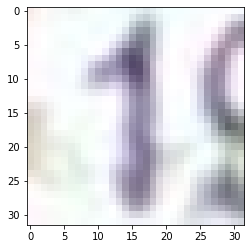

Label:  [1]


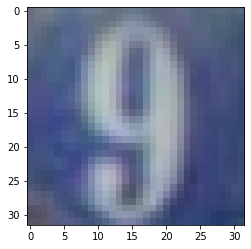

Label:  [9]


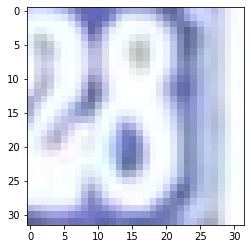

Label:  [8]


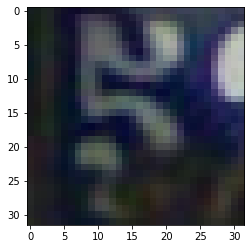

Label:  [5]


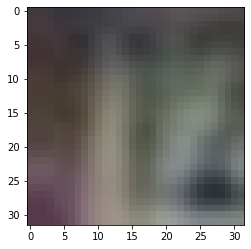

Label:  [1]


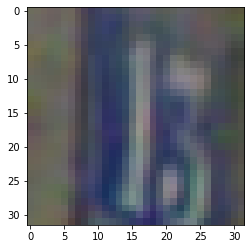

Label:  [1]


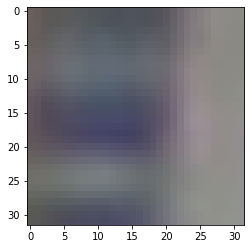

Label:  [2]


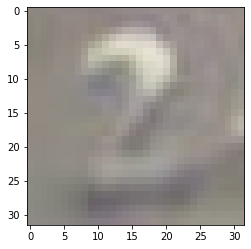

Label:  [2]


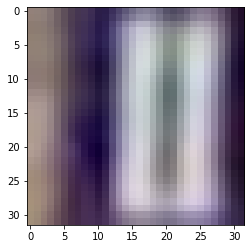

Label:  [1]


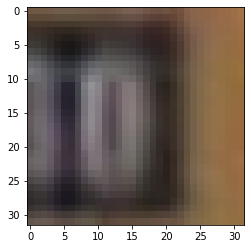

Label:  [10]


In [6]:
for images in glob.glob('/content/hsvn-image/train/*')[:10]:
  x=images.split(sep='/')[4].split(sep='.')[0]
  x=int(x)
  plt.imshow(train_images[x])
  plt.show()
  print('Label: ', train_label[x])

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [7]:
print(train_images.shape)
print(test_images.shape)
print(train_label.shape)
print(test_label.shape)
print(train_images[0].shape)

(73257, 32, 32, 3)
(73257, 32, 32, 3)
(73257, 1)
(26032, 1)
(32, 32, 3)


In [8]:
grey1=[]
for i in range(train_images.shape[0]):
  b,g,r=cv2.split(train_images[i])
  grey=(b/3)+(g/3)+(r/3)
  grey1.append(grey)

In [16]:
grey1_train=np.array(grey1).reshape(73257, 32, 32)

In [17]:
print(grey1_train.shape)

(73257, 32, 32)


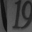

[1]


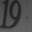

[9]


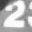

[2]


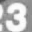

[3]


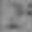

[2]


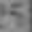

[5]


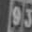

[9]


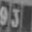

[3]


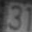

[3]


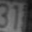

[1]


In [20]:
for i in range(10):
  cv2_imshow(grey1_train[i])
  print(train_label[i])

In [21]:
# Convert train and test images into 'float64' type

grey1_train = grey1_train.astype('float64')
test_images = test_images.astype('float64')

In [79]:
# Convert train and test labels into 'int64' type

train_label = train_label.astype('int64')
test_label = test_label.astype('int64')

In [130]:
train_label[55].dtype

dtype('int64')

In [80]:
grey1_train  = grey1_train/255

In [81]:
test_images=test_images/255

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [82]:
#Creating validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(grey1_train ,train_label,test_size=0.2)
len(X_train), len(X_val)

(58605, 14652)

In [83]:
X_train.shape, train_label.shape

((58605, 32, 32), (73257, 1))

In [84]:
#Importing necessary packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense

In [116]:
input_shape=(32,32)
model=Sequential([
                  Flatten(input_shape=input_shape),
                  Dense(16,activation='relu'),
                  Dense(16,activation='relu'),
                  Dense(16,activation='relu'),
                  Dense(16,activation='relu'),
                  Dense(16,activation='relu'),
                  Dense(10,activation='softmax')

])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                16400     
_________________________________________________________________
dense_44 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_45 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_46 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_47 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_48 (Dense)             (None, 10)               

In [123]:
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
loss=tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(loss=loss,metrics=['accuracy'],optimizer=opt)

In [124]:
# Callbacks
callbacks1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [125]:
# EPOCHS = 10
# checkpoint_filepath = '/content/gdrive/MyDrive/dataset_capstone_week1/'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# # Model weights are saved at the end of every epoch, if it's the best seen
# # so far.
# model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# # The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

In [126]:
X_train.shape, y_train.shape

((58605, 32, 32), (58605, 1))

In [127]:
X_val.shape, y_val.shape

((14652, 32, 32), (14652, 1))

In [128]:
# Training the model with early callback
print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    callbacks=callbacks1,
    validation_data=(X_val, y_val)
)

Fit model on training data
Epoch 1/30


InvalidArgumentError: ignored

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.